In [1]:
import os
import torch
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
class GraphDataset(Dataset):
    def __init__(self, 
                 graph_dir, 
                 graph_files):
        
        self.graph_dir = graph_dir
        self.graph_files = graph_files        
    
    def __len__(self):
        return len(self.graph_files)

    def __getitem__(self, idx):
        
        # single graph
        file = self.graph_files[idx]
        
        # graph paths
        graph_gt_path = os.path.join(self.graph_dir, 'original', file)
        graph_del_path = os.path.join(self.graph_dir, 'deletion', file)
        graph_ins_path = os.path.join(self.graph_dir, 'insertion', file)
        
        # ground truth adj
        graph_gt = torch.from_numpy(nx.to_numpy_array(nx.read_gpickle(graph_gt_path))).float()
        
        # deletion graph embedding
        graph_del = nx.read_gpickle(graph_del_path)
        graph_ins = nx.read_gpickle(graph_ins_path)        
        graph_del_edge_index = np.array(graph_del.edges()).T
        graph_ins_edge_index = np.array(graph_ins.edges()).T
        x = torch.ones(len(graph_del),1)
        
        return graph_gt, graph_del_edge_index, graph_ins_edge_index, x

In [3]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32, 64)

    def forward(self, edge_index, x):

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        z = F.leaky_relu(x)

        return z

In [4]:
# ---------------------
# Early Stop Function
# ---------------------
class EarlyStopping():
    def __init__(self, 
                 tolerance=5):

        self.tolerance = tolerance
        self.loss_min = np.inf
        self.counter = 0
        self.early_stop = False
        self.save_model = False
        
    def __call__(self, loss):
        if loss > self.loss_min:
            self.counter +=1
            self.save_model = False
            if self.counter >= self.tolerance:  
                self.early_stop = True
        else:
            self.save_model = True
            self.loss_min = loss
            self.counter = 0   

In [5]:
# parameters
lr = 1e-4
epochs = 50
batch_size = 1
pos_weights = 28
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_del = GCN().to(device)
model_ins = GCN().to(device)
optimizer = torch.optim.Adam(list(model_del.parameters()) + list(model_ins.parameters()), lr=lr)
criterion= nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weights))
es = EarlyStopping()

# load files
train_files = os.listdir('../graph-data/seattle-graphs/original/')
test_files = os.listdir('../graph-data/west-seattle-graphs/original/')
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

# make datasets
train_data = GraphDataset('../graph-data/seattle-graphs/', train_files)
val_data = GraphDataset('../graph-data/seattle-graphs/', val_files)
test_data = GraphDataset('../graph-data/west-seattle-graphs/', test_files)

# data loader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
loss_tract = []
for e in range(epochs):
    
    # ----------------
    # Training
    # ----------------
    model_del.train()
    model_ins.train()    
    for i, batch in enumerate(tqdm(train_dataloader)):
        
        # load data
        graph_gt, graph_del_edge_index, graph_ins_edge_index, x = batch
        graph_gt = graph_gt.squeeze_(0).to(device)
        labels = graph_gt.flatten()
        graph_del_edge_index = graph_del_edge_index.squeeze_(0).to(device)
        graph_ins_edge_index = graph_ins_edge_index.squeeze_(0).to(device)    
        x = x.squeeze_(0).to(device)
        
        # make prediction
        optimizer.zero_grad() 
        out_del = model_del(graph_del_edge_index, x)
        out_ins = model_ins(graph_ins_edge_index, x) 
        #logits = F.sigmoid(torch.matmul(out_del, out_ins.T)).flatten()
        logits = torch.matmul(out_del, out_ins.T).flatten()
        loss = criterion(logits, labels)
        loss.backward() 
        optimizer.step()
        
    # ----------------
    # Validation
    # ----------------
    model_del.eval()
    model_ins.eval()
    val_losses = []
    for i, batch in enumerate(val_dataloader):
        
        # load data
        graph_gt, graph_del_edge_index, graph_ins_edge_index, x = batch
        graph_gt = graph_gt.squeeze_(0).to(device)
        labels = graph_gt.flatten()
        graph_del_edge_index = graph_del_edge_index.squeeze_(0).to(device)
        graph_ins_edge_index = graph_ins_edge_index.squeeze_(0).to(device)    
        x = x.squeeze_(0).to(device)
        
        # make prediction
        with torch.no_grad():
            out_del = model_del(graph_del_edge_index, x)
            out_ins = model_ins(graph_ins_edge_index, x) 
        logits = torch.matmul(out_del, out_ins.T).flatten()
        loss = criterion(logits, labels)
        val_losses.append(loss.item())
    val_losses = np.mean(val_losses) 
    loss_tract.append(val_losses)
    
    # ----------------
    # Early Stop Check
    # ----------------
    es(val_losses)            
    if es.early_stop:
        print(f" Early Stopping at Epoch {epoch}")
        print(f' Validation Loss: {round(val_losses*1000, 5)}')
        break
        
    print(f'Validation Loss: {val_losses}')

100%|██████████████████████████████████████| 7760/7760 [00:21<00:00, 365.47it/s]


Validation Loss: 1.3068620809812534


100%|██████████████████████████████████████| 7760/7760 [00:21<00:00, 361.42it/s]


Validation Loss: 1.3037302321382083


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 382.64it/s]


Validation Loss: 1.3007826531610234


100%|██████████████████████████████████████| 7760/7760 [00:19<00:00, 389.98it/s]


Validation Loss: 1.2959343355887183


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 386.19it/s]


Validation Loss: 1.2947574224007916


100%|██████████████████████████████████████| 7760/7760 [00:19<00:00, 388.44it/s]


Validation Loss: 1.2926700062713092


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 383.43it/s]


Validation Loss: 1.2919653654789178


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 382.40it/s]


Validation Loss: 1.2920452580114918


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 379.20it/s]


Validation Loss: 1.291955477531097


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 380.88it/s]


Validation Loss: 1.2916342457918275


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 383.81it/s]


Validation Loss: 1.2913934194060908


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 387.84it/s]


Validation Loss: 1.2957409581607628


100%|██████████████████████████████████████| 7760/7760 [00:19<00:00, 392.28it/s]


Validation Loss: 1.29052366753166


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 386.89it/s]


Validation Loss: 1.2908174910108847


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 384.57it/s]


Validation Loss: 1.2904259587356417


100%|██████████████████████████████████████| 7760/7760 [00:20<00:00, 380.35it/s]


Validation Loss: 1.289735717541373


100%|██████████████████████████████████████| 7760/7760 [00:24<00:00, 318.95it/s]


Validation Loss: 1.2913974448952172


100%|██████████████████████████████████████| 7760/7760 [00:21<00:00, 361.38it/s]


Validation Loss: 1.289311826090962


100%|██████████████████████████████████████| 7760/7760 [00:22<00:00, 343.27it/s]


Validation Loss: 1.2918080185407284


100%|██████████████████████████████████████| 7760/7760 [00:28<00:00, 268.26it/s]


Validation Loss: 1.2888642635848264


100%|██████████████████████████████████████| 7760/7760 [00:23<00:00, 326.95it/s]


Validation Loss: 1.288903522532895


100%|██████████████████████████████████████| 7760/7760 [00:23<00:00, 331.36it/s]


Validation Loss: 1.2890235331354107


100%|██████████████████████████████████████| 7760/7760 [00:23<00:00, 331.29it/s]


Validation Loss: 1.288149331839861


100%|██████████████████████████████████████| 7760/7760 [00:23<00:00, 331.27it/s]


Validation Loss: 1.2904568112186596


100%|██████████████████████████████████████| 7760/7760 [00:23<00:00, 328.91it/s]


Validation Loss: 1.2880010102052124


100%|██████████████████████████████████████| 7760/7760 [00:23<00:00, 333.31it/s]


Validation Loss: 1.291124445123993


100%|██████████████████████████████████████| 7760/7760 [00:22<00:00, 339.23it/s]


Validation Loss: 1.2869972099710865


100%|██████████████████████████████████████| 7760/7760 [00:22<00:00, 340.85it/s]


Validation Loss: 1.2885169167921966


100%|██████████████████████████████████████| 7760/7760 [00:22<00:00, 341.97it/s]


Validation Loss: 1.2865199991615182


100%|██████████████████████████████████████| 7760/7760 [00:25<00:00, 300.04it/s]


Validation Loss: 1.2865115701806917


100%|██████████████████████████████████████| 7760/7760 [00:27<00:00, 282.87it/s]


Validation Loss: 1.2856700578542601


100%|██████████████████████████████████████| 7760/7760 [00:24<00:00, 317.04it/s]


Validation Loss: 1.2854840106925434


100%|██████████████████████████████████████| 7760/7760 [00:26<00:00, 290.79it/s]


Validation Loss: 1.2849175743542844


100%|██████████████████████████████████████| 7760/7760 [00:26<00:00, 295.82it/s]


Validation Loss: 1.2848040275059873


100%|██████████████████████████████████████| 7760/7760 [00:30<00:00, 252.79it/s]


Validation Loss: 1.2851834808274465


100%|██████████████████████████████████████| 7760/7760 [00:27<00:00, 277.46it/s]


Validation Loss: 1.2838167781625396


100%|██████████████████████████████████████| 7760/7760 [00:30<00:00, 256.55it/s]


Validation Loss: 1.290489987454022


100%|██████████████████████████████████████| 7760/7760 [00:26<00:00, 289.02it/s]


Validation Loss: 1.2830532063338322


100%|██████████████████████████████████████| 7760/7760 [00:26<00:00, 296.14it/s]


Validation Loss: 1.282792452588971


100%|██████████████████████████████████████| 7760/7760 [00:25<00:00, 307.45it/s]


Validation Loss: 1.2828680278942732


100%|██████████████████████████████████████| 7760/7760 [00:25<00:00, 309.54it/s]


Validation Loss: 1.2815080142104058


100%|██████████████████████████████████████| 7760/7760 [00:27<00:00, 278.01it/s]


Validation Loss: 1.2812122850401515


100%|██████████████████████████████████████| 7760/7760 [00:24<00:00, 319.52it/s]


Validation Loss: 1.2806267657534134


100%|██████████████████████████████████████| 7760/7760 [00:27<00:00, 281.46it/s]


Validation Loss: 1.283725295323762


100%|██████████████████████████████████████| 7760/7760 [00:25<00:00, 298.67it/s]


Validation Loss: 1.2818081153779013


100%|██████████████████████████████████████| 7760/7760 [00:25<00:00, 308.31it/s]


Validation Loss: 1.2808141431416171


100%|██████████████████████████████████████| 7760/7760 [00:26<00:00, 298.24it/s]


Validation Loss: 1.2787999271103294


100%|██████████████████████████████████████| 7760/7760 [00:24<00:00, 313.10it/s]


Validation Loss: 1.2789508324647418


100%|██████████████████████████████████████| 7760/7760 [00:27<00:00, 280.35it/s]


Validation Loss: 1.2822046983697877


100%|██████████████████████████████████████| 7760/7760 [00:25<00:00, 307.72it/s]


Validation Loss: 1.2776069719849428


In [8]:
import matplotlib.pyplot as plt

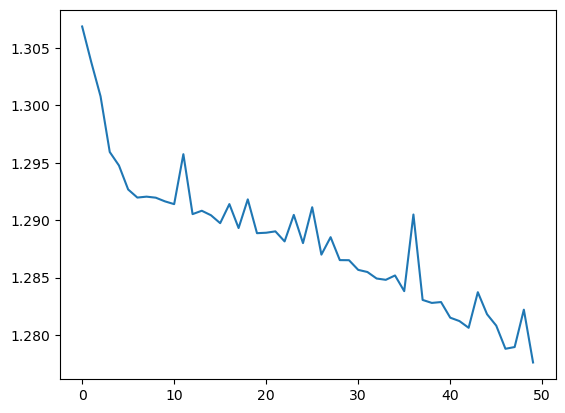

In [9]:
plt.plot(loss_tract)
pass

In [10]:
acc = []
acc_gt = []
for i, batch in enumerate(tqdm(val_dataloader)):
    
    # load data
    graph_gt, graph_del_edge_index, graph_ins_edge_index, x = batch
    graph_gt = graph_gt.squeeze_(0).to(device)
    labels = graph_gt.flatten()
    graph_del_edge_index = graph_del_edge_index.squeeze_(0).to(device)
    graph_ins_edge_index = graph_ins_edge_index.squeeze_(0).to(device)    
    x = x.squeeze_(0).to(device)
    
    # make prediction
    with torch.no_grad():
        out_del = model_del(graph_del_edge_index, x)
        out_ins = model_ins(graph_ins_edge_index, x) 
    A = F.sigmoid(torch.matmul(out_del, out_ins.T)).flatten()
    acc.append(torch.mean(1.0*( 1.0*(A.detach().cpu()>0.5) == labels)).item())
    acc_gt.append(1-torch.mean(labels).item())

100%|████████████████████████████████████████| 863/863 [00:01<00:00, 485.85it/s]


In [23]:
np.mean(acc)

0.48687137558037547

In [24]:
np.mean(acc_gt)

0.9003400147033517